In [4]:
import os
import shutil
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
from rembg import remove
from PIL import Image
import re


## Start

In [14]:
# Definiendo un diccionario con un mapping global a usar en funciones posteriores
classes_mapping = {
    "Tomate": 0,
    "Cebolla": 1,
    "Patata": 2,
    "Lechuga/Endivia": 3,
    "Zanahoria": 4,
    "Calabacines": 5,
    "Pepino": 6,
    "Champiñones": 7,
    "Brocoli": 8,
    "Coliflor": 9,
    "Leche": 10,
    "Huevos": 11,
    "Yogur": 12,
    "Queso": 13,
    "Mantequilla": 14,
    "Merluza": 15,
    "Gambas/Langostinos": 16,
    "Mix de marisco/molusco": 17,
    "Lubina": 18,
    "Salmón": 19,
    "Plátano": 20,
    "Aguacate": 21,
    "Sandía": 22,
    "Limón": 23,
    "Manzana": 24,
    "Carne pollo": 25,
    "Carne cerdo": 26,
    "Carne vacuno": 27,
    "Salchichas": 28,
    "Carne pavo": 29
}


def renumber_yolo_dataset_flat_output(
    dataset_root: str,
    output_root: str,
    target_classes: list,
    splits: list = ['train', 'valid', 'test'],
    image_ext: str = '.jpg'
):
    """
    Filters YOLO dataset into flat 'images/' and 'labels/' folders, mapping to global class IDs.

    Args:
        dataset_root (str): Path to dataset containing split folders.
        output_root (str): Output root for the flat dataset.
        target_classes (list): List of class names to keep (IDs remain as per classes_mapping).
        splits (list): Which splits to process.
        image_ext (str): Image file extension (default .jpg).
    """

    # Load class names from data.yaml in current dataset
    data_yaml_path = os.path.join(dataset_root, 'data.yaml')
    with open(data_yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
    original_names = data_yaml['names']

    # Create mapping: original class ID → global class ID
    original_to_global = {}
    for class_name in target_classes:
        if class_name in original_names and class_name in classes_mapping:
            original_id = original_names.index(class_name)
            global_id = classes_mapping[class_name]
            original_to_global[original_id] = global_id
        else:
            print(f"Warning: '{class_name}' not found in dataset or global map")

    print(f"[{os.path.basename(dataset_root)}] Class mapping: {original_to_global}")

    total_kept, total_skipped = 0, 0

    # Create flat output folders
    out_img_dir = os.path.join(output_root, 'images')
    out_lbl_dir = os.path.join(output_root, 'labels')
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    for split in splits:
        split_img_dir = os.path.join(dataset_root, split, 'images')
        split_lbl_dir = os.path.join(dataset_root, split, 'labels')

        if not os.path.exists(split_img_dir) or not os.path.exists(split_lbl_dir):
            print(f"Skipping {split}: missing directories.")
            continue

        for label_file in os.listdir(split_lbl_dir):
            if not label_file.endswith('.txt'):
                continue

            label_path = os.path.join(split_lbl_dir, label_file)
            with open(label_path, 'r') as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if not parts:
                    continue
                class_id = int(parts[0])
                if class_id in original_to_global:
                    parts[0] = str(original_to_global[class_id])
                    new_lines.append(' '.join(parts) + '\n')

            if new_lines:
                total_kept += 1
                out_lbl_path = os.path.join(out_lbl_dir, label_file)
                with open(out_lbl_path, 'w') as f:
                    f.writelines(new_lines)

                img_file = label_file.replace('.txt', image_ext)
                src_img_path = os.path.join(split_img_dir, img_file)
                dst_img_path = os.path.join(out_img_dir, img_file)

                if os.path.exists(src_img_path):
                    shutil.copyfile(src_img_path, dst_img_path)
                else:
                    print(f"⚠️ Warning: Image not found for {label_file}")
            else:
                total_skipped += 1

    print(f"[{os.path.basename(dataset_root)}] Done: {total_kept} images kept, {total_skipped} skipped.")

    
def count_classes_in_images(label_dir, class_names=None):
    """
    Count how many images each class appears in (based on YOLO label files).
    Ensures all class names (or indices) are reported, even if count is 0.

    Args:
        label_dir (str): Path to directory with YOLO .txt label files.
        class_names (list): Optional list of class names (indexed by ID)

    Returns:
        dict: class_id -> image_count
    """
    class_image_counts = defaultdict(int)

    for file in os.listdir(label_dir):
        if not file.endswith('.txt'):
            continue

        with open(os.path.join(label_dir, file), 'r') as f:
            lines = f.readlines()

        try:
            # Fix: handles both int and float class IDs safely
            classes_in_image = set(int(float(line.split()[0])) for line in lines if line.strip())
        except ValueError as e:
            print(f"⚠️ Error parsing file: {file} — {e}")
            continue

        for class_id in classes_in_image:
            class_image_counts[class_id] += 1

    # Ensure all class IDs are accounted for, even with 0
    total_classes = len(class_names) if class_names else max(class_image_counts.keys(), default=-1) + 1

    print(f"\nClass distribution in '{label_dir}':\n")
    for class_id in range(total_classes):
        count = class_image_counts.get(class_id, 0)
        class_name = class_names[class_id] if class_names and class_id < len(class_names) else f"Class {class_id}"
        print(f"{class_name:30} → {count} image(s)")

    return dict(class_image_counts)

def plot_class_image_distribution(class_counts, class_names=None, title='Class Occurrence in Images'):
    """
    Plots a bar chart of how many images each class appears in.

    Args:
        class_counts (dict): Dictionary of class_id → image count.
        class_names (list): Optional list of class names.
        title (str): Title for the chart.
    """
    # Sort by frequency
    sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    class_ids = [item[0] for item in sorted_items]
    counts = [item[1] for item in sorted_items]

    if class_names:
        labels = [class_names[i] if i < len(class_names) else f"Class {i}" for i in class_ids]
    else:
        labels = [f"Class {i}" for i in class_ids]

    plt.figure(figsize=(14, 6))
    plt.bar(labels, counts)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Images')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [44]:
target_classes = [
    "Tomate", "Cebolla", "Patata", "Lechuga/Endivia", "Zanahoria",
    "Calabacines", "Pepino", "Champiñones", "Brocoli", "Coliflor",
    "Leche", "Huevos", "Yogur", "Queso", "Mantequilla",
    "Merluza", "Gambas/Langostinos", "Mix de marisco/molusco", "Lubina", "Salmón",
    "Plátano", "Aguacate", "Sandía", "Limón", "Manzana", "Carne pollo", "Carne cerdo", "Carne vacuno", "Salchichas", "Carne pavo"
]
dataset_root = r'..\dataset\YOLO - Raw datasets\Raw Dataset 1'
output_root = r'..\dataset\YOLO - Clean dataset\Clean dataset 1'
renumber_yolo_dataset_flat_output(dataset_root=dataset_root, output_root=output_root, target_classes=target_classes)

[Raw Dataset 1] Class mapping: {37: 0, 27: 1, 30: 2, 20: 3, 7: 4, 23: 7, 5: 8, 22: 10, 12: 11, 24: 12, 8: 13, 6: 14, 31: 16, 1: 20, 19: 23, 0: 24, 9: 25, 17: 26, 2: 27}
[Raw Dataset 1] Done: 7526 images kept, 115 skipped.


In [47]:
count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels', class_names=target_classes)


Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels':

Tomate                         → 4621 image(s)
Cebolla                        → 3152 image(s)
Patata                         → 4233 image(s)
Lechuga/Endivia                → 87 image(s)
Zanahoria                      → 3027 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 0 image(s)
Champiñones                    → 3170 image(s)
Brocoli                        → 84 image(s)
Coliflor                       → 0 image(s)
Leche                          → 2811 image(s)
Huevos                         → 2519 image(s)
Yogur                          → 116 image(s)
Queso                          → 4440 image(s)
Mantequilla                    → 3137 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3554 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(s)
Plát

{10: 2811,
 14: 3137,
 23: 110,
 11: 2519,
 3: 87,
 7: 3170,
 2: 4233,
 4: 3027,
 12: 116,
 26: 1467,
 0: 4621,
 24: 2146,
 13: 4440,
 25: 4241,
 1: 3152,
 8: 84,
 27: 2005,
 20: 3350,
 16: 3554}


Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels':

Tomate                         → 4621 image(s)
Cebolla                        → 3152 image(s)
Patata                         → 4233 image(s)
Lechuga/Endivia                → 87 image(s)
Zanahoria                      → 3027 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 0 image(s)
Champiñones                    → 3170 image(s)
Brocoli                        → 84 image(s)
Coliflor                       → 0 image(s)
Leche                          → 2811 image(s)
Huevos                         → 2519 image(s)
Yogur                          → 116 image(s)
Queso                          → 4440 image(s)
Mantequilla                    → 3137 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3554 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(s)
Plát

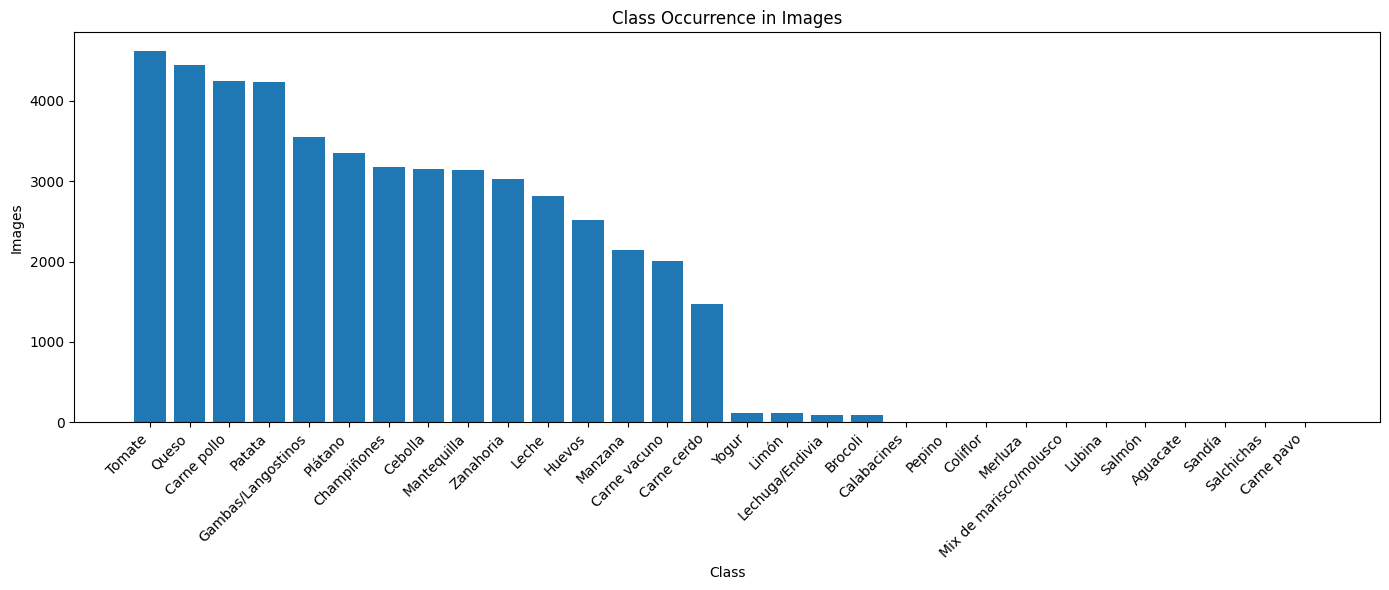

In [48]:
counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)


In [49]:
# Procesando el dataset 2
dataset_root = r'..\dataset\YOLO - Raw datasets\Raw Dataset 2'
output_root = r'..\dataset\YOLO - Clean dataset\Clean dataset 1'
renumber_yolo_dataset_flat_output(dataset_root=dataset_root, output_root=output_root, target_classes=target_classes)

[Raw Dataset 2] Class mapping: {20: 0, 13: 3, 6: 4, 9: 6, 16: 10, 10: 11, 21: 12, 7: 13, 5: 14, 2: 20, 1: 21, 12: 23, 0: 24, 8: 25}
[Raw Dataset 2] Done: 3041 images kept, 69 skipped.



Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels':

Tomate                         → 5899 image(s)
Cebolla                        → 3152 image(s)
Patata                         → 4233 image(s)
Lechuga/Endivia                → 689 image(s)
Zanahoria                      → 4213 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 643 image(s)
Champiñones                    → 3170 image(s)
Brocoli                        → 84 image(s)
Coliflor                       → 0 image(s)
Leche                          → 4147 image(s)
Huevos                         → 4157 image(s)
Yogur                          → 1084 image(s)
Queso                          → 5784 image(s)
Mantequilla                    → 4315 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3554 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(s)


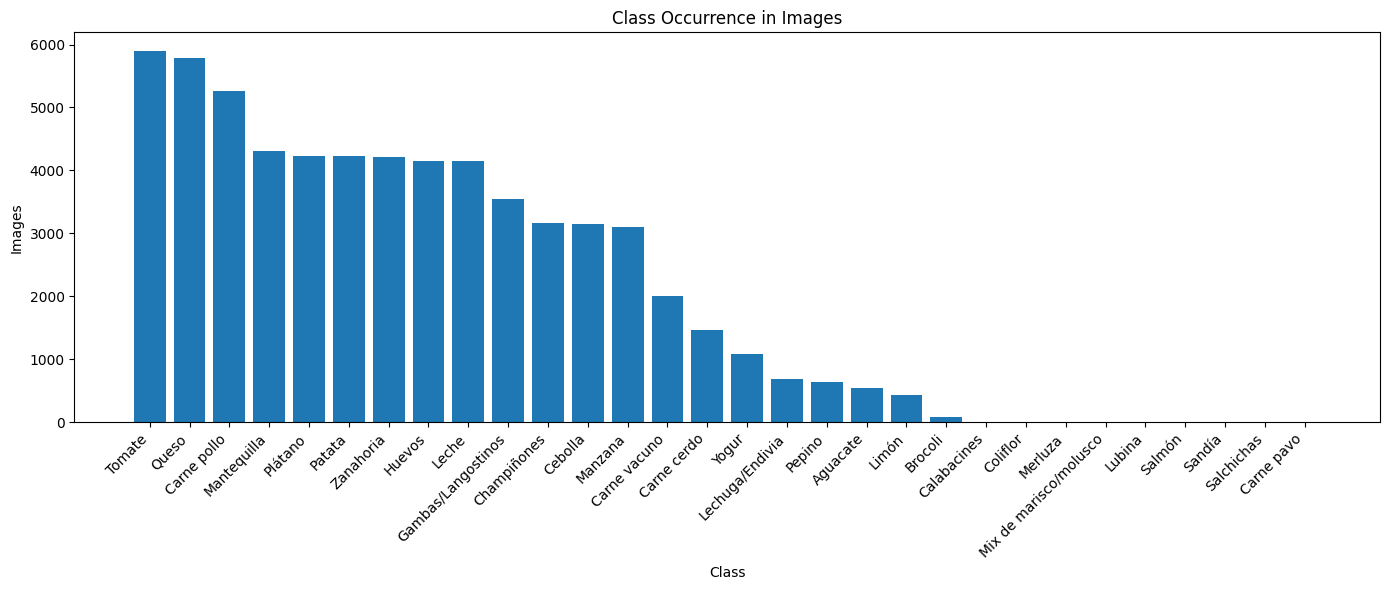

In [50]:
counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)


In [51]:
# Procesando el dataset 3
dataset_root = r'..\dataset\YOLO - Raw datasets\Raw Dataset 3'
output_root = r'..\dataset\YOLO - Clean dataset\Clean dataset 1'
renumber_yolo_dataset_flat_output(dataset_root=dataset_root, output_root=output_root, target_classes=target_classes)

[Raw Dataset 3] Class mapping: {12: 0, 5: 1, 8: 2, 53: 3, 26: 4, 59: 7, 2: 8, 3: 9, 39: 11, 87: 12, 28: 13, 25: 14, 76: 16, 0: 20, 4: 23, 13: 24, 29: 25, 48: 26, 21: 27, 75: 28}
[Raw Dataset 3] Done: 1655 images kept, 486 skipped.



Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels':

Tomate                         → 5991 image(s)
Cebolla                        → 3162 image(s)
Patata                         → 4245 image(s)
Lechuga/Endivia                → 802 image(s)
Zanahoria                      → 4496 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 643 image(s)
Champiñones                    → 3238 image(s)
Brocoli                        → 124 image(s)
Coliflor                       → 30 image(s)
Leche                          → 4147 image(s)
Huevos                         → 4724 image(s)
Yogur                          → 1701 image(s)
Queso                          → 6498 image(s)
Mantequilla                    → 4747 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3609 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(s

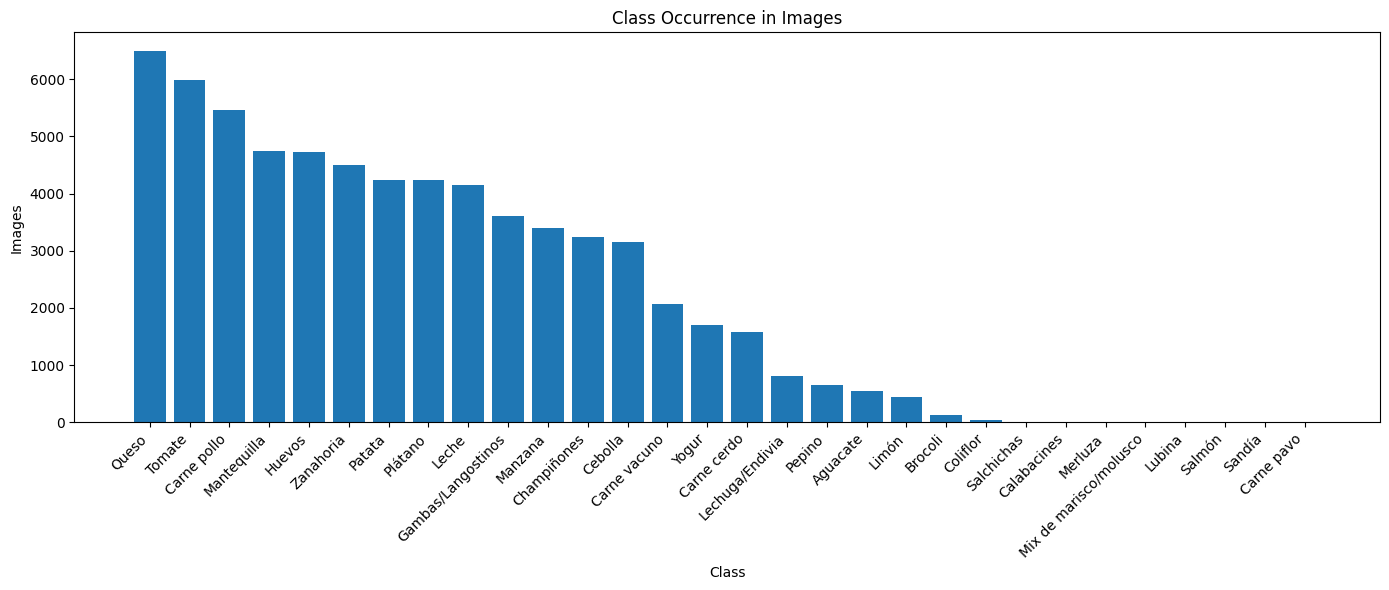

In [52]:
counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)


In [53]:
# Procesando el dataset 4
dataset_root = r'..\dataset\YOLO - Raw datasets\Raw Dataset 4'
output_root = r'..\dataset\YOLO - Clean dataset\Clean dataset 1'
renumber_yolo_dataset_flat_output(dataset_root=dataset_root, output_root=output_root, target_classes=target_classes)

[Raw Dataset 4] Class mapping: {33: 0, 4: 1, 12: 3, 36: 4, 22: 6, 3: 8, 11: 10, 8: 11, 35: 12, 29: 13, 15: 14, 27: 20, 1: 21, 13: 23, 16: 24, 31: 28, 21: 29}
[Raw Dataset 4] Done: 1883 images kept, 140 skipped.



Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels':

Tomate                         → 6379 image(s)
Cebolla                        → 3212 image(s)
Patata                         → 4245 image(s)
Lechuga/Endivia                → 1216 image(s)
Zanahoria                      → 4737 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 751 image(s)
Champiñones                    → 3238 image(s)
Brocoli                        → 322 image(s)
Coliflor                       → 30 image(s)
Leche                          → 4664 image(s)
Huevos                         → 4987 image(s)
Yogur                          → 2413 image(s)
Queso                          → 6775 image(s)
Mantequilla                    → 4904 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3609 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(

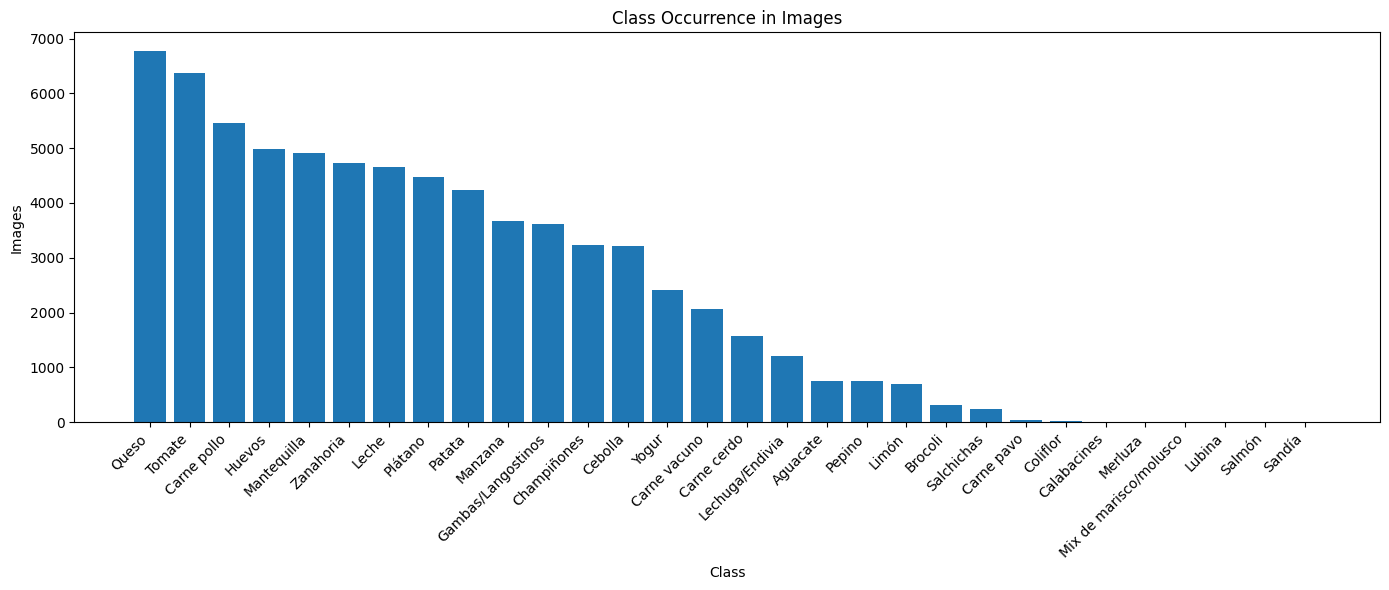

In [54]:
counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)

In [15]:
def split_yolo_dataset(
    image_dir,
    label_dir,
    output_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42
):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    random.seed(seed)

    # Step 1: Match all image-label pairs
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    matched_pairs = []
    for img_file in image_files:
        base = os.path.splitext(img_file)[0]
        label_file = f"{base}.txt"
        if os.path.exists(os.path.join(label_dir, label_file)):
            matched_pairs.append((img_file, label_file))

    # Step 2: Shuffle and split
    random.shuffle(matched_pairs)
    total = len(matched_pairs)
    n_train = int(total * train_ratio)
    n_val = int(total * val_ratio)

    train_set = matched_pairs[:n_train]
    val_set = matched_pairs[n_train:n_train + n_val]
    test_set = matched_pairs[n_train + n_val:]

    # Step 3: Copy files
    def copy_files(pairs, split_name):
        img_out = os.path.join(output_dir, split_name, "images")
        lbl_out = os.path.join(output_dir, split_name, "labels")
        os.makedirs(img_out, exist_ok=True)
        os.makedirs(lbl_out, exist_ok=True)
        for img, lbl in pairs:
            shutil.copyfile(os.path.join(image_dir, img), os.path.join(img_out, img))
            shutil.copyfile(os.path.join(label_dir, lbl), os.path.join(lbl_out, lbl))

    copy_files(train_set, "train")
    copy_files(val_set, "val")
    copy_files(test_set, "test")

    # Summary
    print(f"✅ Split complete:")
    print(f"   → Train: {len(train_set)}")
    print(f"   → Val:   {len(val_set)}")
    print(f"   → Test:  {len(test_set)}")

# Example usage:
# split_yolo_dataset("images", "labels", "output_dataset")


In [60]:
split_yolo_dataset(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\images', r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels',r'..\dataset\YOLO - Clean dataset\Clean dataset 1\split_dataset')

✅ Split complete:
   → Train: 9873
   → Val:   2115
   → Test:  2117


## Next step

- Vemos que clases tienen pocas imágenes
- Encontramos tanto fotos de neveras con la clase dentro
- Construimos imágenes sintéticas (encontramos ingredientes en diferentes posiciones, se les quita el background, y a través de un script se ponen aleatoriamente en la nevera para crear imágenes realísticas de la nevera)


## Quitando fondos

Poner un antes y después de las fotos (con fondo, sin fondo)

In [4]:
input_dir = r'..\dataset\YOLO - Raw datasets\Ingredients\Raw Ingredients - with background'
output_dir = r'..\dataset\YOLO - Raw datasets\Ingredients\Ingredients - without background'

os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(input_dir):
    if file.endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, file)
        output_path = os.path.join(output_dir, file.replace('.jpg', '.png'))

        with open(input_path, 'rb') as inp:
            raw = inp.read()
            result = remove(raw)

        with open(output_path, 'wb') as out:
            out.write(result)

print("✔ Proceso completato. Se han eliminado los fondos y las nuevas imágenes se han guardado en:", output_dir)


✔ Proceso completato. Se han eliminado los fondos y las nuevas imágenes se han guardado en: ..\dataset\YOLO - Raw datasets\Ingredients\Ingredients - without background


# Randomizando fondos + objetos

Problemas encontrados:
- A veces el objeto es más grande que la nevera (se ha añadido una restricción de tamaño proporcional al tamaño de la foto de la nevera)
- A veces el objeto está raro y flotando/está en el suelo, en el techo de la nevera (se han obtenido coordenadas de dónde podría estar el producto)

Para resolver los problemos, se han añadido bounding boxes a las diferentes fotos que sirven de fondo de nevera donde se van a posicionar los objetos (clases de ingredientes) a detectar. De este modo, teniendo las coordinadas de los bounding boxes, con el código se puede limitar donde van a ser posicionados los objetos (de forma aleatoria para similar todas las posibles situaciones) pero dentro de unos espacios definidos para que sean posiciones lógicas y con sentido.

Se han dibujado manualmente los bounding boxes para 20 fotos diferentes de neveras vacías. Se han eliminado los fondos de las imágenes con un script.

Post-processing:
- Cambiamos la foto del producto ligerante con data augmentation techniques

In [9]:
import os
import random
import re
from PIL import Image

# === CONFIGURATION ===

bg_path = r"..\dataset\YOLO - Raw datasets\Fridge\Fridge pictures labeled\images"
label_path = r"..\dataset\YOLO - Raw datasets\Fridge\Fridge pictures labeled\labels"
obj_path = r"..\dataset\YOLO - Raw datasets\Ingredients\Ingredients - without background"
output_images = r"..\dataset\YOLO - Raw datasets\Synthetic Dataset\images"
output_labels = r"..\dataset\YOLO - Raw datasets\Synthetic Dataset\labels"

os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

# === CLASS LIST FROM data.yaml ===
class_names = [
    "Tomate", "Cebolla", "Patata", "Lechuga/Endivia", "Zanahoria",
    "Calabacines", "Pepino", "Champiñones", "Brocoli", "Coliflor",
    "Leche", "Huevos", "Yogur", "Queso", "Mantequilla",
    "Merluza", "Gambas/Langostinos", "Mix de marisco/molusco", "Lubina", "Salmón",
    "Plátano", "Aguacate", "Sandía", "Limón", "Manzana",
    "Carne pollo", "Carne cerdo", "Carne vacuno", "Salchichas", "Carne pavo"
]
class_to_id = {name.lower(): i for i, name in enumerate(class_names)}

MAX_OBJECTS_PER_ZONE = 2
MAX_IOU_ALLOWED = 0.3

# === UTILITIES ===

def normalize_class(name_raw):
    return name_raw.strip().lower().replace("-", "/").replace("_", "/")

def extract_clean_classname(filename):
    base_name = os.path.splitext(filename)[0]
    clean_name = re.sub(r'[\s_\-]*\d+$', '', base_name).strip()
    return normalize_class(clean_name)

def load_yolo_boxes(label_file, img_w, img_h):
    boxes = []
    if not os.path.exists(label_file):
        return boxes
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            _, x_c, y_c, w, h = map(float, parts)
            x1 = int((x_c - w / 2) * img_w)
            y1 = int((y_c - h / 2) * img_h)
            x2 = int((x_c + w / 2) * img_w)
            y2 = int((y_c + h / 2) * img_h)
            boxes.append((x1, y1, x2, y2))
    return boxes

def iou(box1, box2):
    xa = max(box1[0], box2[0])
    ya = max(box1[1], box2[1])
    xb = min(box1[2], box2[2])
    yb = min(box1[3], box2[3])
    inter_area = max(0, xb - xa) * max(0, yb - ya)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# === COLLECT OBJECT FILES ===
object_files = [f for f in os.listdir(obj_path) if f.lower().endswith('.png')]

# === LOAD BACKGROUND FILES ===
bg_files = [f for f in os.listdir(bg_path) if f.lower().endswith(('.jpg', '.png'))]

# === GENERATE SYNTHETIC IMAGES ===
for i in range(1000):  # Number of synthetic images
    bg_file = random.choice(bg_files)
    bg = Image.open(os.path.join(bg_path, bg_file)).convert("RGBA")
    bg_w, bg_h = bg.size

    label_file = os.path.join(label_path, os.path.splitext(bg_file)[0] + ".txt")
    allowed_zones = load_yolo_boxes(label_file, bg_w, bg_h)

    if not allowed_zones:
        print(f"⚠️ Skipping {bg_file}: no allowed zones found.")
        continue

    label_lines = []
    placed_boxes = []
    zone_usage = {}
    num_objects = random.randint(5, 10)

    for _ in range(num_objects):
        obj_file = random.choice(object_files)
        normalized_name = extract_clean_classname(obj_file)

        matched_id = class_to_id.get(normalized_name)
        if matched_id is None:
            print(f"⚠️ Skipping unknown class: {obj_file} → '{normalized_name}'")
            continue

        obj_orig = Image.open(os.path.join(obj_path, obj_file)).convert("RGBA")
        obj_w, obj_h = obj_orig.size
        placed = False

        for scale_threshold in [0.2, 0.05]:
            zones_shuffled = allowed_zones.copy()
            random.shuffle(zones_shuffled)

            for (x1, y1, x2, y2) in zones_shuffled:
                zone_key = (x1, y1, x2, y2)
                if zone_usage.get(zone_key, 0) >= MAX_OBJECTS_PER_ZONE:
                    continue

                box_w = x2 - x1
                box_h = y2 - y1

                scale = min(box_w / obj_w, box_h / obj_h, 1.0)
                if scale < scale_threshold:
                    continue

                obj = obj_orig.resize((int(obj_w * scale), int(obj_h * scale)))
                jitter = random.uniform(0.85, 1.0)
                obj = obj.resize((int(obj.width * jitter), int(obj.height * jitter)))

                if obj.width > box_w or obj.height > box_h:
                    continue

                pos_x = random.randint(x1, x2 - obj.width)
                pos_y = random.randint(y1, y2 - obj.height)
                new_box = (pos_x, pos_y, pos_x + obj.width, pos_y + obj.height)

                if any(iou(new_box, b) > MAX_IOU_ALLOWED for b in placed_boxes):
                    continue

                # Place object
                bg.paste(obj, (pos_x, pos_y), obj)

                x_center = (pos_x + obj.width / 2) / bg_w
                y_center = (pos_y + obj.height / 2) / bg_h
                w_norm = obj.width / bg_w
                h_norm = obj.height / bg_h

                label_lines.append(f"{matched_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")
                placed_boxes.append(new_box)
                zone_usage[zone_key] = zone_usage.get(zone_key, 0) + 1
                placed = True
                break
            if placed:
                break

        if not placed:
            print(f"⚠️ Couldn’t place object {obj_file} — too large, overlapping, or zone full.")

    if label_lines:
        img_name = f"fridge_synth_{i}.jpg"
        lbl_name = f"fridge_synth_{i}.txt"
        bg.convert("RGB").save(os.path.join(output_images, img_name))
        with open(os.path.join(output_labels, lbl_name), "w") as f:
            f.write("\n".join(label_lines))
    else:
        print(f"⚠️ Skipped fridge_synth_{i} — no valid objects placed.")

print("✅ Done: Synthetic images generated with hybrid clutter control.")


⚠️ Couldn’t place object Aguacate 4.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Pepino 2.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Manzana 4.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Salmón 6.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Lubina 3.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Yogur 5.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Calabacines 4.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Merluza 2.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Manzana 4.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Carne pavo 1.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Salmón 17.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Mix de marisco-molusco 4.png — too large, overlapping, or zone full.
⚠️ Couldn’t place object Manzana 1

## Data Augmentation

In [10]:
import os
import albumentations as A
import cv2
from tqdm import tqdm

def augment_synthetic_dataset(
    img_dir, label_dir, output_img_dir, output_label_dir, num_aug_per_image=3
):
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    # Albumentations pipeline with YOLO bbox support
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.3),
        A.Rotate(limit=15, p=0.4),
        A.GaussianBlur(blur_limit=3, p=0.3),
        A.GaussNoise(p=0.3)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]

    for img_file in tqdm(image_files, desc="Augmenting images"):
        img_path = os.path.join(img_dir, img_file)
        lbl_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')

        if not os.path.exists(lbl_path):
            print(f"⚠️ Skipping {img_file} — label file missing")
            continue

        image = cv2.imread(img_path)
        if image is None:
            print(f"⚠️ Failed to read {img_path}")
            continue
        h, w = image.shape[:2]

        # Load and parse YOLO labels
        with open(lbl_path, 'r') as f:
            lines = f.readlines()

        if not lines:
            print(f"⚠️ Skipping {img_file} — empty label file")
            continue

        bboxes = []
        class_labels = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            try:
                class_id = int(float(parts[0]))  # Fix: handle float class IDs
                bbox = list(map(float, parts[1:]))  # [x_center, y_center, w, h]
                bboxes.append(bbox)
                class_labels.append(class_id)
            except ValueError:
                print(f"⚠️ Invalid label in {lbl_path}: {line}")
                continue

        # Generate N augmentations per image
        for j in range(num_aug_per_image):
            try:
                augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)

                aug_img = augmented['image']
                aug_bboxes = augmented['bboxes']
                aug_labels = augmented['class_labels']

                if not aug_bboxes:
                    print(f"⚠️ Skipping {img_file}_aug{j} — no valid bboxes after augmentation")
                    continue

                new_name = os.path.splitext(img_file)[0] + f"_aug{j}"
                aug_img_path = os.path.join(output_img_dir, new_name + '.jpg')
                aug_lbl_path = os.path.join(output_label_dir, new_name + '.txt')

                cv2.imwrite(aug_img_path, aug_img)

                # Save corrected YOLO label
                with open(aug_lbl_path, 'w') as f:
                    for label, bbox in zip(aug_labels, aug_bboxes):
                        class_id = int(label)  # FIX: ensure integer class ID
                        bbox_str = ' '.join(f'{x:.6f}' for x in bbox)
                        f.write(f"{class_id} {bbox_str}\n")

            except Exception as e:
                print(f"⚠️ Failed to augment {img_file} (aug{j}): {e}")


In [11]:
image_dir = r'..\dataset\YOLO - Raw datasets\Synthetic Dataset\images'
label_dir = r'..\dataset\YOLO - Raw datasets\Synthetic Dataset\labels'
augmented_images = r'..\dataset\YOLO - Raw datasets\Synthetic Dataset\augmented_images'
augmented_lables = r'..\dataset\YOLO - Raw datasets\Synthetic Dataset\augmented_label'
augment_synthetic_dataset(img_dir=image_dir, label_dir=label_dir, output_img_dir=augmented_images, output_label_dir=augmented_lables)

Augmenting images:   0%|          | 0/1000 [00:00<?, ?it/s]

Augmenting images:  20%|█▉        | 199/1000 [00:06<00:23, 34.44it/s]

⚠️ Failed to augment fridge_synth_273.jpg (aug0): Expected x_min for bbox [-4.991889e-07  8.015625e-01  2.328125e-01  9.749995e-01  1.700000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
⚠️ Failed to augment fridge_synth_273.jpg (aug1): Expected x_min for bbox [-4.991889e-07  8.015625e-01  2.328125e-01  9.749995e-01  1.700000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
⚠️ Failed to augment fridge_synth_273.jpg (aug2): Expected x_min for bbox [-4.991889e-07  8.015625e-01  2.328125e-01  9.749995e-01  1.700000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Augmenting images:  42%|████▏     | 418/1000 [00:14<00:16, 34.45it/s]

⚠️ Failed to augment fridge_synth_470.jpg (aug0): Expected x_min for bbox [-5.0291419e-07  8.2343745e-01  1.2031250e-01  9.4375050e-01
  9.0000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
⚠️ Failed to augment fridge_synth_470.jpg (aug1): Expected x_min for bbox [-5.0291419e-07  8.2343745e-01  1.2031250e-01  9.4375050e-01
  9.0000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
⚠️ Failed to augment fridge_synth_470.jpg (aug2): Expected x_min for bbox [-5.0291419e-07  8.2343745e-01  1.2031250e-01  9.4375050e-01
  9.0000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Augmenting images:  44%|████▍     | 438/1000 [00:15<00:15, 35.13it/s]

⚠️ Failed to augment fridge_synth_486.jpg (aug0): Expected x_min for bbox [-4.9918890e-07  7.3437446e-01  2.3906249e-01  9.7343749e-01
  2.7000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
⚠️ Failed to augment fridge_synth_486.jpg (aug1): Expected x_min for bbox [-4.9918890e-07  7.3437446e-01  2.3906249e-01  9.7343749e-01
  2.7000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
⚠️ Failed to augment fridge_synth_486.jpg (aug2): Expected x_min for bbox [-4.9918890e-07  7.3437446e-01  2.3906249e-01  9.7343749e-01
  2.7000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Augmenting images:  49%|████▉     | 493/1000 [00:16<00:14, 35.56it/s]

⚠️ Failed to augment fridge_synth_537.jpg (aug0): Expected x_min for bbox [-5.029142e-07  8.203125e-01  1.203125e-01  9.234375e-01  9.000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
⚠️ Failed to augment fridge_synth_537.jpg (aug1): Expected x_min for bbox [-5.029142e-07  8.203125e-01  1.203125e-01  9.234375e-01  9.000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
⚠️ Failed to augment fridge_synth_537.jpg (aug2): Expected x_min for bbox [-5.029142e-07  8.203125e-01  1.203125e-01  9.234375e-01  9.000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Augmenting images:  61%|██████    | 607/1000 [00:20<00:10, 36.95it/s]

⚠️ Failed to augment fridge_synth_639.jpg (aug0): Expected x_min for bbox [-4.9918890e-07  4.5624948e-01  2.0156249e-01  6.5781248e-01
  1.8000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
⚠️ Failed to augment fridge_synth_639.jpg (aug1): Expected x_min for bbox [-4.9918890e-07  4.5624948e-01  2.0156249e-01  6.5781248e-01
  1.8000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
⚠️ Failed to augment fridge_synth_639.jpg (aug2): Expected x_min for bbox [-4.9918890e-07  4.5624948e-01  2.0156249e-01  6.5781248e-01
  1.8000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
⚠️ Failed to augment fridge_synth_641.jpg (aug0): Expected x_min for bbox [-5.066395e-07  7.124995e-01  2.281245e-01  9.406245e-01  2.300000e+01] to be in the range [0.0, 1.0], got -5.066394805908203e-07.
⚠️ Failed to augment fridge_synth_641.jpg (aug1): Expected x_min for bbox [-5.066395e-07  7.124995e-01  2.281245e-01  9.406245e-01  2.300000e+01] to be in the ran

Augmenting images: 100%|██████████| 1000/1000 [00:34<00:00, 29.02it/s]

⚠️ Failed to augment fridge_synth_992.jpg (aug0): Expected x_min for bbox [-5.0291419e-07  8.2656246e-01  1.2031250e-01  9.4687551e-01
  2.4000000e+01] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
⚠️ Failed to augment fridge_synth_992.jpg (aug1): Expected x_min for bbox [-5.0291419e-07  8.2656246e-01  1.2031250e-01  9.4687551e-01
  2.4000000e+01] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
⚠️ Failed to augment fridge_synth_992.jpg (aug2): Expected x_min for bbox [-5.0291419e-07  8.2656246e-01  1.2031250e-01  9.4687551e-01
  2.4000000e+01] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
⚠️ Failed to augment fridge_synth_995.jpg (aug0): Expected x_min for bbox [-5.0291419e-07  8.2187504e-01  1.2187450e-01  9.6562499e-01
  1.2000000e+01] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
⚠️ Failed to augment fridge_synth_995.jpg (aug1): Expected x_min for bbox [-5.0291419e-07  8.2187504e-01  1.2187450e-01  9.6562499e-01
  1.2000000e+01] to b

Con el dataset sintético, se cuentan otra vez las clases y la cantidad de veces que aparece cada clase.
Primero hacemos renumbering otra vez (para que concuerde con el general)


Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 2\labels':

Tomate                         → 6379 image(s)
Cebolla                        → 3212 image(s)
Patata                         → 4245 image(s)
Lechuga/Endivia                → 2029 image(s)
Zanahoria                      → 4737 image(s)
Calabacines                    → 711 image(s)
Pepino                         → 1621 image(s)
Champiñones                    → 3238 image(s)
Brocoli                        → 1015 image(s)
Coliflor                       → 717 image(s)
Leche                          → 4664 image(s)
Huevos                         → 5170 image(s)
Yogur                          → 3565 image(s)
Queso                          → 6775 image(s)
Mantequilla                    → 4904 image(s)
Merluza                        → 966 image(s)
Gambas/Langostinos             → 3609 image(s)
Mix de marisco/molusco         → 777 image(s)
Lubina                         → 1101 image(s)
Salmón                       

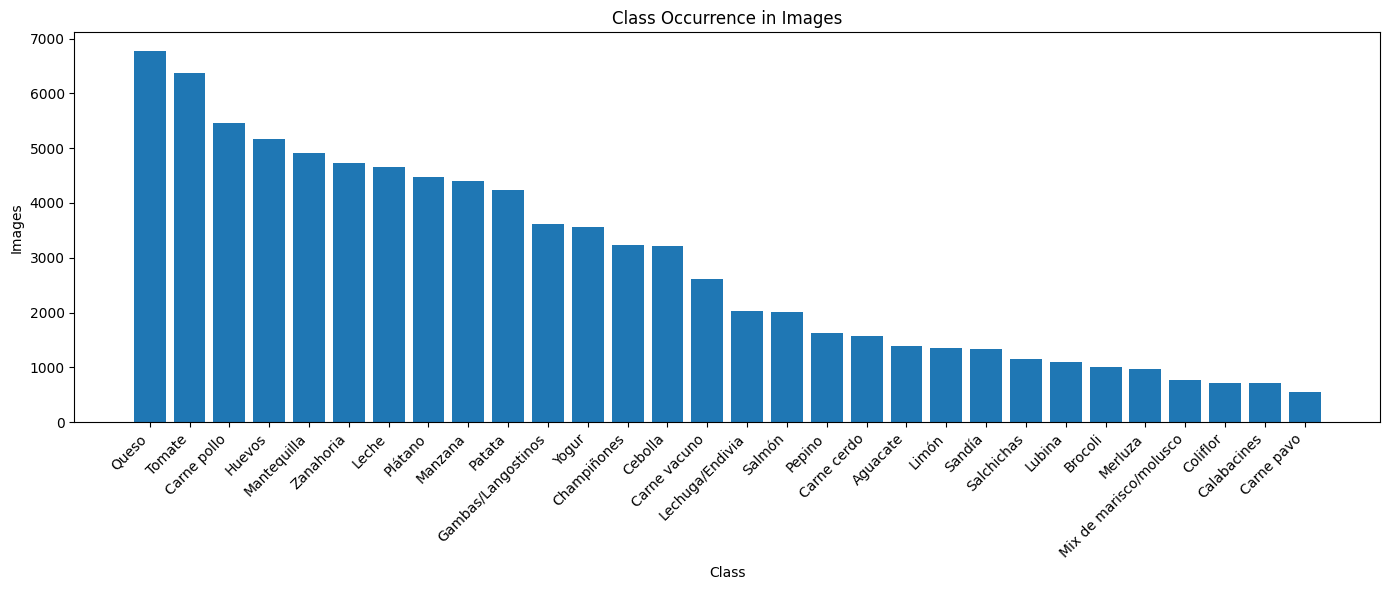

In [12]:
target_classes = [
    "Tomate", "Cebolla", "Patata", "Lechuga/Endivia", "Zanahoria",
    "Calabacines", "Pepino", "Champiñones", "Brocoli", "Coliflor",
    "Leche", "Huevos", "Yogur", "Queso", "Mantequilla",
    "Merluza", "Gambas/Langostinos", "Mix de marisco/molusco", "Lubina", "Salmón",
    "Plátano", "Aguacate", "Sandía", "Limón", "Manzana", "Carne pollo", "Carne cerdo", "Carne vacuno", "Salchichas", "Carne pavo"
]

counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 2\labels', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)

In [17]:
img_dir = r'..\dataset\YOLO - Clean dataset\Clean dataset 2\images'
label_dir = r'..\dataset\YOLO - Clean dataset\Clean dataset 2\labels'
output_dir = r'..\dataset\YOLO - Clean dataset\Clean dataset 2\split dataset'
split_yolo_dataset(image_dir=img_dir, label_dir=label_dir, output_dir=output_dir)

✅ Split complete:
   → Train: 11956
   → Val:   2562
   → Test:  2563
